In [48]:
import pandas as pd
import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

In [49]:
# not_alpaca_images[0].shape

input_size = (300, 300)

def preprocess_dataset(image):
    image = tf.image.resize(image, (input_size[0], input_size[1]))
    return image.numpy()

In [50]:
# walk the directory containing alpaca/not alpaca and read them in. 
# might be different shapes
# all have 3 channels
alpaca_images = []
for dirname, _, filenames in os.walk('dataset/alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            alpaca_images.append(imnp)

not_alpaca_images = []
for dirname, _, filenames in os.walk('dataset/not alpaca'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            imnp = preprocess_dataset(imnp)
            not_alpaca_images.append(imnp)

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


In [51]:
alpaca_images[0].shape

(300, 300, 3)

In [52]:
# cnn = keras.Sequential(
#     keras.Input(shape=(input_size[0], input_size[1], 3)),
#     layers.Conv2D(16, (3, 3), activation='relu'),
#     layers.AveragePooling2D(),
# )

In [53]:
# data preprocessing
alpaca_images = np.asarray(alpaca_images) / 255.
not_alpaca_images = np.asarray(not_alpaca_images) / 255.

In [54]:
print(np.max(alpaca_images), np.min(alpaca_images))
print(np.max(not_alpaca_images), np.min(not_alpaca_images))

1.0 0.0
1.0 0.0


In [55]:
print(len(alpaca_images))
print(len(not_alpaca_images))

142
183


In [56]:
# loading data
X = np.concatenate((alpaca_images, not_alpaca_images), axis=0)
X.shape

(325, 300, 300, 3)

In [105]:
# 0 -> alpaca_images, 1-> not_alpaca_images
y = np.concatenate((np.zeros(alpaca_images.shape[0], dtype=int), np.ones(not_alpaca_images.shape[0], dtype=int)), axis=0)
# y = np.asarray(y).astype('float32').reshape((-1,1))

y.shape

(325,)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(227, 300, 300, 3) (227,)
(98, 300, 300, 3) (98,)


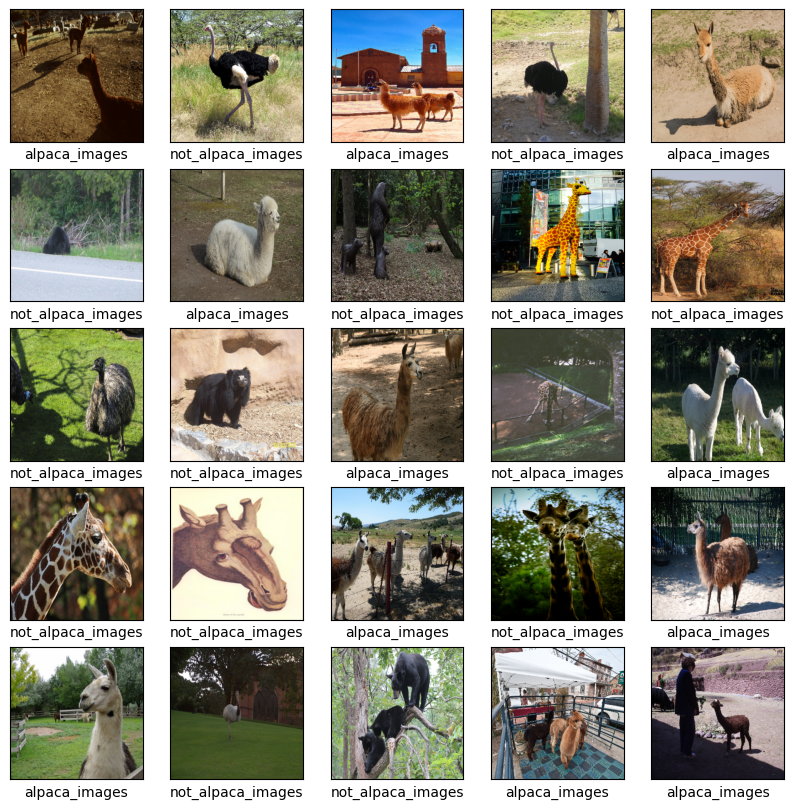

In [60]:
class_names = ['alpaca_images', 'not_alpaca_images']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

In [109]:
cnn2d = keras.Sequential((
    # input layer
    keras.Input(shape=(input_size[0], input_size[1], 3)),
    # convolutional layer1 + ActivationLayer1
    layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer1
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer2 + ActivationLayer2
    layers.Conv2D(filters=12, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # PoolingLayer2
    layers.AveragePooling2D(pool_size=(2, 2)),
    
    # convolutional layer3 + ActivationLayer33
    layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
    # Dense layer1
    layers.Flatten(name='flatten'),
    layers.Dense(12),
    
    # output layer
    layers.Dense(1, activation='softmax')
))

In [110]:
cnn2d.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 average_pooling2d_17 (Avera  (None, 149, 149, 16)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_26 (Conv2D)          (None, 147, 147, 12)      1740      
                                                                 
 average_pooling2d_18 (Avera  (None, 73, 73, 12)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_27 (Conv2D)          (None, 71, 71, 8)         872       
                                                                 
 flatten (Flatten)           (None, 40328)            

In [114]:
"""
## Train the model
"""

batch_size = 128
epochs = 3 # enough for a quick demo. increase to 15 for slightly better performance.

cnn2d.compile(loss="mean_squared_logarithmic_error", optimizer="adam")

cnn2d.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

cnn2d.save("keras_2dcnn.saved_model")

Epoch 1/3


2023-03-08 14:34:54.933947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 320ms/step - loss: 0.2336 - val_loss: 0.0000e+00
Epoch 2/3


2023-03-08 14:34:55.992945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 252ms/step - loss: 0.2336 - val_loss: 0.0000e+00
Epoch 3/3
3/3 [==============================] - 1s 247ms/step - loss: 0.2336 - val_loss: 0.0000e+00


INFO:tensorflow:Assets written to: keras_2dcnn.saved_model/assets


INFO:tensorflow:Assets written to: keras_2dcnn.saved_model/assets
